# Auto-encodeur Convolutif et traitement d'images (CNNs)

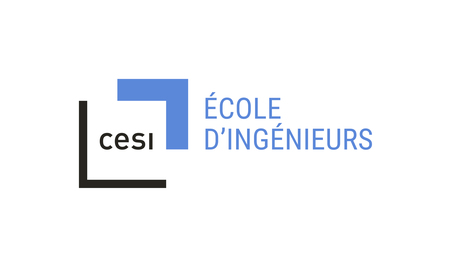


Les auto-encodeurs ont été largement appliqués dans la réduction de dimension, on l'a vu dans le Workshop précédent. Ici, on va voir son utilisation pour la réduction du bruit d'image. Et on verra que les opérations de convolutions qu'on avait utilisées l'année dernière pour faire du denoising seront de nouveau utilisées.

# 1. Traitement d'images

## 1.1 Auto-encodeur convolutif

Pour modéliser les données d'image, on utilise les réseaux de neurones convolutifs (CNN ou ConvNet).<br>
Comme évoqué dans les précédents WS, une image en noir et blanc est *ensemble de pixels, où chaque pixel est représenté par un nombre compris entre 0 et 255.*

Vous avez déjà vu l'année dernière les opérations de convolution pour manipuler des images (et même faire du débruitage). Mais ici, on va utiliser ces opérations de convolution dans un réseau de neurones. Plus précisément, on va utiliser un auto-encodeur. Les auto-encodeurs ont été largement appliqués dans la réduction de dimension (et vous l'avez vu), mais aussi pour la réduction du bruit d'image, notamment en utilisant des opérations de convolution. On peut alors parler d'auto-encodeur convolutifs. Pourquoi les auto-encodeurs convolutifs sont adaptés aux données de type images ?

<blockquote>Tout simplement parce qu’une image contient beaucoup, mais alors beaucoup de données en entrée. Imaginez avec une petite image de 100×100 pixels en couleurs … delà nous fait déjà 100x100x3 donc 30 000 données à envoyer dans le réseau de neurones (et c’est une petite image!). Si vous commencez à empiler couches et neurones, très vite le nombre de paramètres de votre réseau va exploser et le nombre de calculs va croitre de manière exponentielle … de quoi mettre par terre votre machine !

Il fallait donc trouver une autre approche que celle classique des réseaux ANN (ou Perceptron Multicouches). L’idée derrière les filtres a convolution est qu’ils permettent de trouver des patterns, des formes dans les images (rappelez vous l’article précédent qui permettait de trouver les contours par exemple). Les CNN permettent en effet de déterminer de manière progressive les différentes formes puis de les assembler pour en trouver d’autres.

L’exemple classique est que les premières couches d’un tel réseau trouve les formes de base d’un visage: les traits principaux, puis on va détecteur les premières formes: nez, bouche, yeux, etc., puis pour finir le visage et pourquoi par reconnaître la personne, etc.
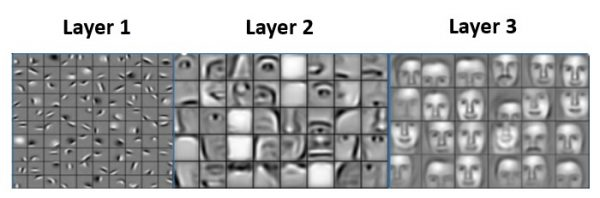
</blockquote>

Finalement, un auto-encodeur convolutif n'est qu'une variante de CNN. Vous vous souvenez comment fonction un CNN ? Comment ça s'appliquerait à une image ?
<blockquote> Un CNN applique généralement 3 types d’opérations différentes à une image afin d’en extraire les informations pertinentes.

Ces 3 types d’opérations sont les suivantes :
* La convolution
* Le pooling
* La fonction d’activation de type ReLU
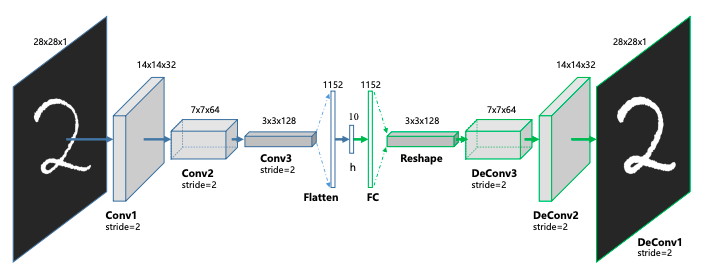
</blockquote>

## 1.2 Dataset

Pour la suite de ce WS, on utilisera une fois de plus **MNIST**, mais cette fois, on va charger l'ensemble de données d'entraînement et de test à partir de Keras, avec la méthode `load_data` de `datasets.mnist`. 

In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Charger l'ensemble de données MNIST
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# x_train : Les images d'entraînement (images en niveaux de gris)
# x_test : Les images de test (images en niveaux de gris)


In [27]:
# Data pre-processing 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Commençons par écrire une fonction qui permet de visualiser $n$ premiers enregistrements en noir et blanc. 

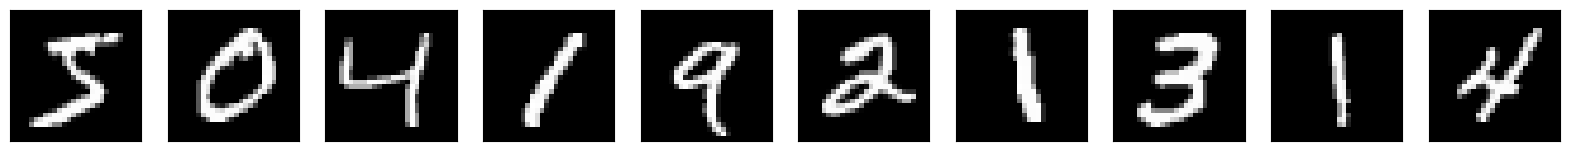

In [28]:
import matplotlib.pyplot as plt

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)  # Crée un sous-graphique pour chaque image
        plt.imshow(X[i].reshape(28, 28), cmap='gray')  # Affiche l'image en niveaux de gris
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Utilisation de la fonction pour afficher les 10 premières images de x_train par exemple
display_image(x_train, 10)


Voyons ce que ça donne :

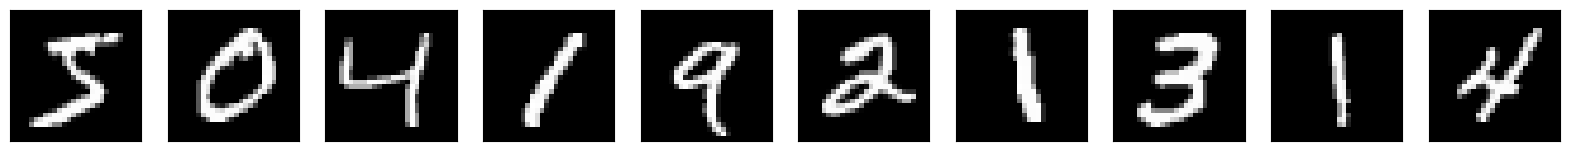

In [29]:
display_image(x_train, n=10)

## 1.3 Auto-encodeur de réduction de bruit (denoiser)

Le bruit dans une image est généralement assez visible à l'œil nu et peut être très gênant. Avec un auto-encodeur, il est possible de supprimer les grains de bruit des images afin de voir clairement les principaux objets ou pour un pre-processing avant d'appliquer un auto-encodeur de classification par exemple.
Pour cela, il faut créer un modèle d'auto-encodeur convolutif composé de :
* encodeur composé de trois couches convolutives
* décodeur composé de l'inverse des couches de l'encodeur. 

Quelles sont les données d'entrée et de sortie de l'auto-encodeur ?
<em>À COMPLÉTER</em>


Etant donné que le dataset ne contient pas d'images bruitées, nous allons générer un bruit aléatoire gaussian sur les images. Plus précisément, on va générer un bruit aléatoire *x_train_noisy* et *x_test_noisy* à partir de *x_train* et *x_test*

*Tip* : utiliser la méthode *normal* de *np.random*

In [30]:
import numpy as np

# Facteur de bruit
noise_factor = 0.5

# Générer un bruit aléatoire gaussien pour les images d'entraînement et de test
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Assurez-vous que les valeurs des pixels sont dans la plage [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


Visualisez les images d'origines puis les images bruitées.

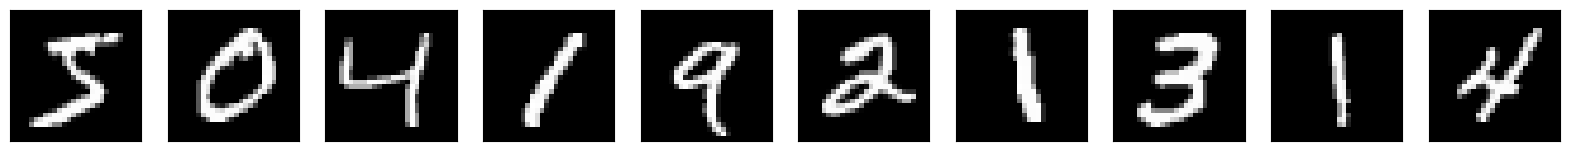

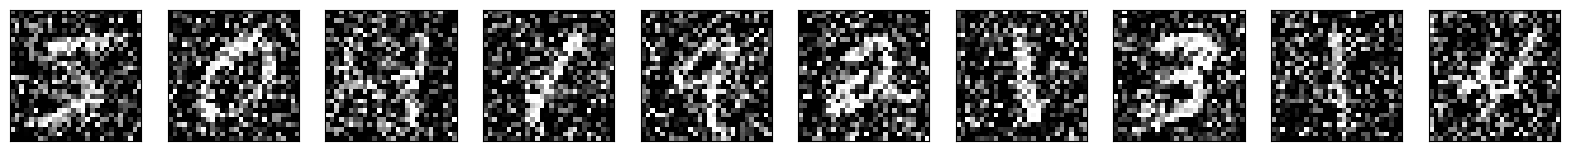

In [31]:
# Visualisation des images d'origine
display_image(x_train, 10)  # Affiche les 10 premières images d'origine

# Visualisation des images bruitées
display_image(x_train_noisy, 10)  # Affiche les 10 premières images bruitées

In [32]:
# Configurations principales de nos modèles
IMG_SIZE          = 28                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 20              # nombre epoch alogithme debruiter
BATCH_SIZE        = 128               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

###### Encodeur

Il faut maintenant écrire un code qui permet d'encoder une image en utilisant trois couches de convolution.

*Tip* : Utiliser la classe Input, Conv2D, MaxPooling2D et UpSampling2D

In [33]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

from keras.layers import BatchNormalization

# Définir l'entrée du modèle
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))


# Convolution 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Convolution 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# Créer le modèle de l'encodeur
encoder = Model(input_img, encoded)

###### Décodeur

Passon au décodeur. Écrivez un code qui permet de décoder une image encodée selon l'architecture du réseau de neurones décrite auparavent. 

In [34]:
# Decoding #

# DeConv1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)



In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error

# Déclarer le modèle complet de l'auto-encodeur
autoencoder = Model(input_img, decoded)

# Compiler le modèle en utilisant l'optimiseur Adam et la perte mean_squared_error
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')


# Afficher un résumé du modèle
autoencoder.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256 

###### Entrainement de l'auto-encodeur

On va ensuite entraîner l'auto-encodeur en utilisant les constantes définit au début (`NB_EPOCHS_DENOISE,BATCH_SIZE`)

In [36]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
def train_autoencoder():
    history = autoencoder.fit(x_train_noisy, x_train, epochs=NB_EPOCHS_DENOISE, batch_size=BATCH_SIZE,
                              shuffle=True, validation_data=(x_test_noisy, x_test),
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
    return history
history = train_autoencoder()

Epoch 1/20
469/469 [==============================] - 7s 9ms/step - loss: 0.0246 - val_loss: 0.0200
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 9/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 10/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0102 - val_loss: 0.0107

313/313 [==============================] - 1s 2ms/step


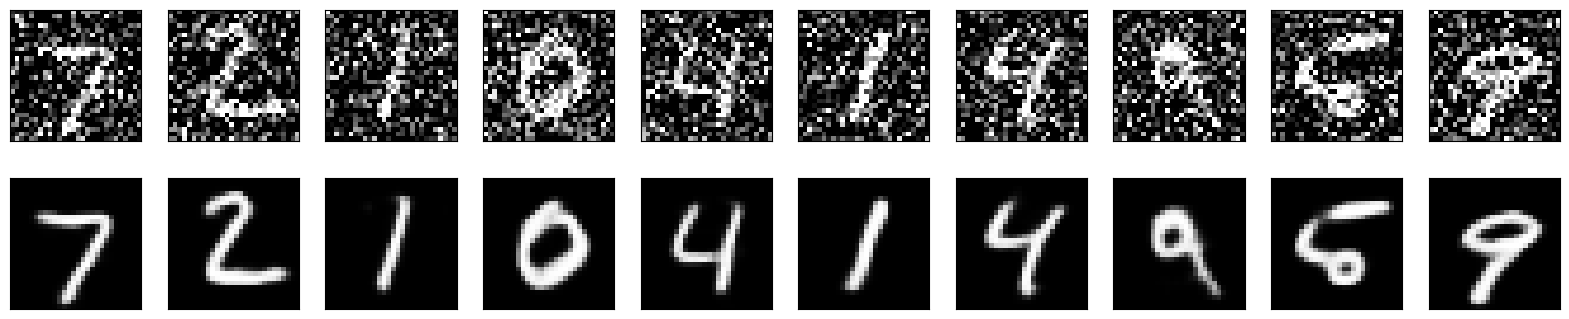

In [38]:
def visualize_reconstructed_images(autoencoder, x_test_noisy):
    reconstructed_images = autoencoder.predict(x_test_noisy)
    # Plot original and reconstructed images
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Visualize reconstructed images
visualize_reconstructed_images(autoencoder, x_test_noisy)


Affichez maintenant la courbe d'apprentissage. Que pensez-vous des performances du modèle ?

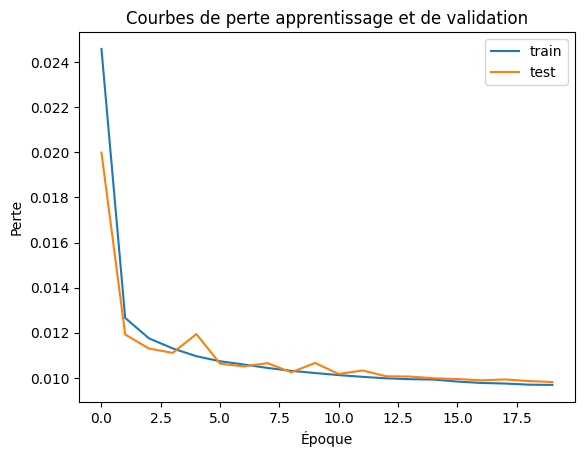

In [39]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbes de perte apprentissage et de validation')
plt.show()

Que pensez-vous des performances du modèle ?
<em>À COMPLÉTER</em>


# 1.4 Sauvgarde de l'auto-encodeur

L'entrainement de l'auto-encodeur sans utilisation de puissance de calcul (GPU) peut prendre beaucoup de temps. Usuellement, nous sauvegardons le modèle entraîné en local ou sur un serveur distant pour l'utiliser ultérieurement afin de traiter les nouvelles données (d'ailleurs, vous verrez une utilisation avancée de cette technique, le transfert learning, dès la semaine prochaine).
Pour sauvegarder le modèle `autoencoder`, utiliser la méthode `save`.

In [40]:
# save the model

model_filename = "autoencoder_model.h5"
autoencoder.save(model_filename)
print(f"Modèle de l'auto-encodeur sauvegardé sous le nom : {model_filename}")

Modèle de l'auto-encodeur sauvegardé sous le nom : autoencoder_model.h5


In [41]:
# Utilisez l'auto-encodeur pour prédire les images décodées à partir des images bruitées
decoded_imgs = autoencoder.predict(x_test_noisy)


313/313 [==============================] - 1s 2ms/step


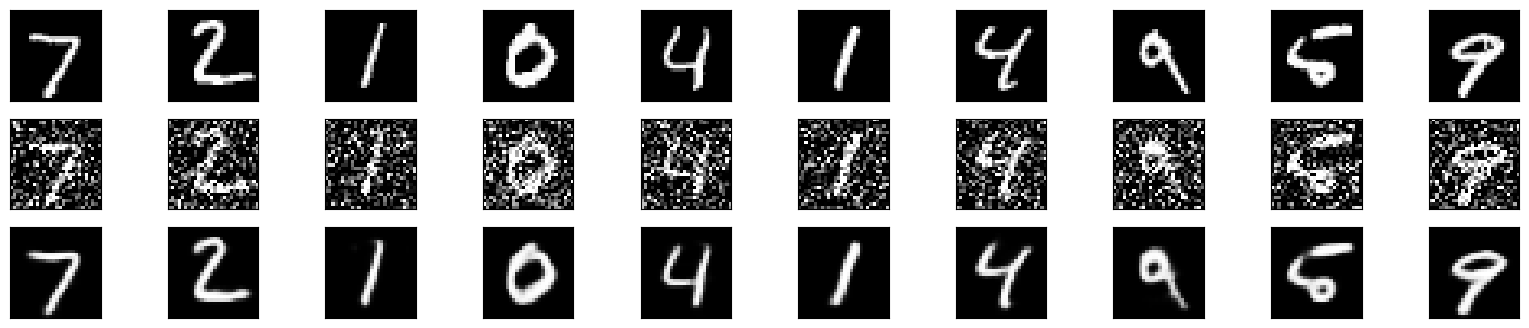

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Affiche quelques exemples d'images originales, bruitées et débruitées
n = 10  # Le nombre d'exemples à afficher
plt.figure(figsize=(20, 4))

for i in range(n):
    # Image originale
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Image bruitée
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Image débruitée
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()